In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import optimize

import btrdb
from btrdb.utils.timez import ns_delta, ns_to_datetime, to_nanoseconds

import yaml

##  Connecting to the API
Visit your profile on ni4ai.org to get an API key.

In [2]:
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)
    

In [3]:
#Establishing the connecting to the server
db = btrdb.connect(config['connection']['api_url'], apikey=config['connection']['api_key'])


In [4]:
#View streams in the collection
db.list_collections("lndunn/PQdata")


['lndunn/PQdata/epri/event21877',
 'lndunn/PQdata/epri/event2850',
 'lndunn/PQdata/epri/event3433',
 'lndunn/PQdata/epri/event21837',
 'lndunn/PQdata/epri/event21870',
 'lndunn/PQdata/epri/event2812',
 'lndunn/PQdata/epri/event3429',
 'lndunn/PQdata/epri/event0793',
 'lndunn/PQdata/epri/event2885',
 'lndunn/PQdata/epri/event21880',
 'lndunn/PQdata/epri/event21849',
 'lndunn/PQdata/epri/event21876',
 'lndunn/PQdata/epri/event0001',
 'lndunn/PQdata/epri/event0366',
 'lndunn/PQdata/epri/event3458',
 'lndunn/PQdata/epri/event2826',
 'lndunn/PQdata/epri/event0207',
 'lndunn/PQdata/epri/event2914',
 'lndunn/PQdata/epri/event21881',
 'lndunn/PQdata/site_2',
 'lndunn/PQdata/epri/event21871',
 'lndunn/PQdata/epri/event0775',
 'lndunn/PQdata/epri/event0722',
 'lndunn/PQdata/epri/event2786',
 'lndunn/PQdata/epri/event2948',
 'lndunn/PQdata/epri/event0799',
 'lndunn/PQdata/epri/event2994',
 'lndunn/PQdata/epri/event0064',
 'lndunn/PQdata/epri/event3430',
 'lndunn/PQdata/epri/event2949',
 'lndunn/P

In [5]:
#Choose streams for a particular collection
streams = db.streams_in_collection('lndunn/PQdata/underground')
streams

[<Stream collection=lndunn/PQdata/underground name=phB_amp>,
 <Stream collection=lndunn/PQdata/underground name=phC_volt>,
 <Stream collection=lndunn/PQdata/underground name=phA_amp>,
 <Stream collection=lndunn/PQdata/underground name=phC_amp>,
 <Stream collection=lndunn/PQdata/underground name=phA_volt>,
 <Stream collection=lndunn/PQdata/underground name=phB_volt>]

In [6]:
# Print metadata (tags, annotations) for the first stream in the collection
print(streams[0].tags())
print(streams[0].annotations())

{'name': 'phB_amp', 'unit': 'amps', 'ingress': '', 'distiller': ''}
({'documentation': 'https://grouper.ieee.org/groups/td/pq/data/downloads/XLPE_data.pdf', 'equipment_specs': '{"cable type": "XLPE underground cable", "cable rating": "8 kV", "Year of installation": "1991", "PT ratio": "8050:115", "CT ratio": "600:5"}', 'measurement_params': '{"Sampling mode": "Continuous (gap-less) data recording", "Sampling rate": "64 samples/cycle", "Measured signals": "Three-phase bus voltages and feeder currents"}', 'source': 'https://drive.google.com/drive/folders/0B6vSVhUYNe86TGQ3bmgwdG1ySnM'}, 13)


In [7]:
# Read the docs
streams[0].annotations()[0]['documentation']

'https://grouper.ieee.org/groups/td/pq/data/downloads/XLPE_data.pdf'

In [8]:
df = pd.DataFrame(columns=['Collection','Name','Units','UUID'])
for ix, stream in enumerate(streams):
  tags = stream.tags()
  df.loc[ix] = [stream.collection, stream.name, tags['unit'], stream.uuid]

df

,Collection,Name,Units,UUID
0,lndunn/PQdata/underground,phB_amp,amps,2e08ba24-61ea-4fa7-bb72-24f005150ac2
1,lndunn/PQdata/underground,phC_volt,volts,47dfc415-1704-4447-88a4-43e68645ab0f
2,lndunn/PQdata/underground,phA_amp,amps,9cc032a1-6c32-4c3a-bb37-7c87da13dc4b
3,lndunn/PQdata/underground,phC_amp,amps,33f91f08-ed6f-49fb-a83e-1dc9889d5b36
4,lndunn/PQdata/underground,phA_volt,volts,ca93b50c-612c-4d10-b211-fe98f21ea39c
5,lndunn/PQdata/underground,phB_volt,volts,a63f75e8-38f5-4f2f-8327-8fd8ae94013b


In [9]:
idx = df['Name'].str.contains('volt')
df[idx]

,Collection,Name,Units,UUID
1,lndunn/PQdata/underground,phC_volt,volts,47dfc415-1704-4447-88a4-43e68645ab0f
4,lndunn/PQdata/underground,phA_volt,volts,ca93b50c-612c-4d10-b211-fe98f21ea39c
5,lndunn/PQdata/underground,phB_volt,volts,a63f75e8-38f5-4f2f-8327-8fd8ae94013b


In [10]:
stream = streams[0]

(start_time, start_val), _ = stream.earliest()
(end_time, end_val), _ = stream.latest()

print(ns_to_datetime(start_time), ns_to_datetime(end_time))

2020-01-01 00:00:00.000127+00:00 2020-01-01 23:59:59.999866+00:00


In [11]:
pw = 38
points, _ = zip(*stream.aligned_windows(start_time, end_time, pw))
print(len(points))

315


In [12]:
def get_stats(points, attrs=['time','min','max','mean','stddev','count']):
  df = pd.DataFrame(columns=attrs)
  for i, point in enumerate(points):
    df.loc[i] = [getattr(point, attr) for attr in attrs]
  return df

In [13]:
data = get_stats(points)

In [14]:
data.head()

,time,min,max,mean,stddev,count
0,1.577837e+18,-4.579173,4.574318,-0.000128,3.070760,169423.0
1,1.577837e+18,-4.629345,4.626648,-0.000490,3.072483,1055265.0
2,1.577837e+18,-4.759901,4.757204,-0.000338,3.066348,1055265.0
3,1.577837e+18,-4.838667,4.840825,-0.000426,3.201099,1055264.0
4,1.577838e+18,-4.842443,4.846759,-0.000377,3.201372,1055264.0


In [15]:
df

,Collection,Name,Units,UUID
0,lndunn/PQdata/underground,phB_amp,amps,2e08ba24-61ea-4fa7-bb72-24f005150ac2
1,lndunn/PQdata/underground,phC_volt,volts,47dfc415-1704-4447-88a4-43e68645ab0f
2,lndunn/PQdata/underground,phA_amp,amps,9cc032a1-6c32-4c3a-bb37-7c87da13dc4b
3,lndunn/PQdata/underground,phC_amp,amps,33f91f08-ed6f-49fb-a83e-1dc9889d5b36
4,lndunn/PQdata/underground,phA_volt,volts,ca93b50c-612c-4d10-b211-fe98f21ea39c
5,lndunn/PQdata/underground,phB_volt,volts,a63f75e8-38f5-4f2f-8327-8fd8ae94013b


## Query individual points

In [16]:
dt = ns_delta(seconds=1/60.)
_streams = db.streams(*df['UUID'].tolist())
data = _streams.filter(start_time, start_time+10*dt).to_dataframe()

In [17]:
data.head(n=10)

,lndunn/PQdata/underground/phB_amp,lndunn/PQdata/underground/phC_volt,lndunn/PQdata/underground/phA_amp,lndunn/PQdata/underground/phC_amp,lndunn/PQdata/underground/phA_volt,lndunn/PQdata/underground/phB_volt
time,,,,,,
1577836800000126720,-2.190860,130.124481,4.445920,-2.253441,-148.154160,12.106109
1577836800000387328,-1.774915,139.155502,4.280297,-2.521027,-140.903442,-2.524803
1577836800000647680,-1.312574,147.539154,4.035369,-2.752467,-131.678207,-16.378853
1577836800000908288,-0.812469,153.365616,3.759691,-2.936433,-121.287666,-29.585516
1577836800001168640,-0.367931,155.760941,3.546054,-3.137662,-109.828949,-44.701965
1577836800001429248,0.067436,156.861496,3.373418,-3.412261,-96.881233,-60.433434
1577836800001689600,0.528159,157.508881,3.186755,-3.704663,-82.023743,-75.452774
1577836800001950208,1.032580,157.832581,2.969881,-3.994908,-66.357010,-89.695259
1577836800002210560,1.500855,157.088089,2.717940,-4.204769,-50.755020,-102.772446


In [18]:
data = data.rename(columns=dict(zip(data.keys(), [k.split('/')[-1] for k in data.keys()])))
data.head()

,phB_amp,phC_volt,phA_amp,phC_amp,phA_volt,phB_volt
time,,,,,,
1577836800000126720,-2.190860,130.124481,4.445920,-2.253441,-148.154160,12.106109
1577836800000387328,-1.774915,139.155502,4.280297,-2.521027,-140.903442,-2.524803
1577836800000647680,-1.312574,147.539154,4.035369,-2.752467,-131.678207,-16.378853
1577836800000908288,-0.812469,153.365616,3.759691,-2.936433,-121.287666,-29.585516
1577836800001168640,-0.367931,155.760941,3.546054,-3.137662,-109.828949,-44.701965


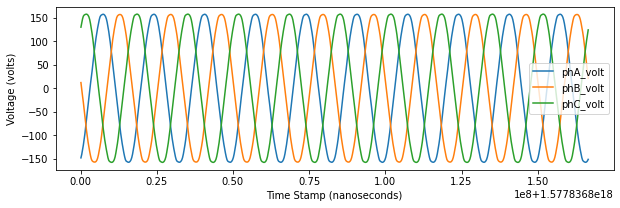

In [19]:
data[['phA_volt','phB_volt','phC_volt']].plot(figsize=(10,3))
plt.xlabel('Time Stamp (nanoseconds)')
plt.ylabel('Voltage (volts)')
plt.show()

In [20]:
def calc_sine(params, t):
  freq, phase, magnitude = params
  return magnitude * np.sin(2*np.pi*freq * t/1e9 - np.radians(phase))

def func(params, t, y):
  return calc_sine(params, t) - y

t = data.index
y = data['phA_volt']

p0 = [60, 0, y.max()]

result = optimize.least_squares(func, p0, args=(t, y))
print(dict(zip(['frequency', 'phase angle', 'magnitude'], result.x)))

{'frequency': 60.000000563943715, 'phase angle': 0.0, 'magnitude': 166.96462395809692}


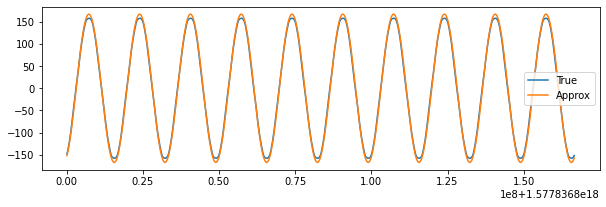

In [21]:
y_hat = calc_sine(result.x, t)

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(t, y, label='True')
ax.plot(t, y_hat, label='Approx')
plt.legend()
plt.show()

In [22]:
p0 = {'phA_volt': [60., 0, data['phA_volt'].max()],
      'phB_volt': [60., 120, data['phB_volt'].max()], 
      'phC_volt': [60., -120, data['phC_volt'].max()]}

params = {}
for phase in ['phA_volt', 'phB_volt', 'phC_volt']:
    y = data[phase]
    result = optimize.least_squares(func, p0[phase], args=(t, y), xtol=1e-9)
  
    params[phase] = dict(zip(['frequency','phase','magnitude'], result.x.tolist()))

In [23]:
import json

print(json.dumps(params, indent=3))

{
   "phA_volt": {
      "frequency": 60.000000563943715,
      "phase": 0.0,
      "magnitude": 166.96462395809692
   },
   "phB_volt": {
      "frequency": 60.00000072744839,
      "phase": 120.0,
      "magnitude": 157.2608760387304
   },
   "phC_volt": {
      "frequency": 60.00000082284371,
      "phase": 58.90666679794896,
      "magnitude": 262.33381668307567
   }
}
